In [4]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from Bio import Phylo

##############################################################################
# 1. LOAD / PREPARE YOUR DATA
##############################################################################

# ----------------------------------------------------------------------------
# Assume you already have a DataFrame called df with shape: (num_samples, num_otus).
# Rows = samples, Columns = OTUs, and the values are abundances (counts, relative abundances, etc.).
# If you have extra metadata columns, remove or separate them so that only OTU columns remain.

# Example (dummy) df creation if you need to simulate:
# Comment this out if you already have df
np.random.seed(42)
df = pd.DataFrame(
    np.random.randint(0, 100, (10, 5)),  # 10 samples, 5 OTUs
    columns=["OTU_1", "OTU_2", "OTU_3", "OTU_4", "OTU_5"]
)

print("DataFrame shape:", df.shape)
print("DataFrame head:\n", df.head())

##############################################################################
# 2. LOAD / PARSE YOUR PHYLOGENETIC TREE
##############################################################################

# ----------------------------------------------------------------------------
# Suppose you have a phylogenetic tree in Newick format saved in "tree.nwk".
# Make sure the tip labels in the tree correspond to your OTU names in df.columns.

# tree = Phylo.read("tree.nwk", "newick")

# ----------------------------------------------------------------------------
# For demonstration, we’ll create a simple example tree with Biopython:
# You can comment this out and load your actual tree above.

from io import StringIO
example_tree_newick = "(OTU_4:0.1,(OTU_2:0.2,(OTU_1:0.1,OTU_3:0.3):0.2):0.3,OTU_5:0.4);"
tree = Phylo.read(StringIO(example_tree_newick), "newick")

print("\nPhylogenetic Tree Tips (OTUs) in order:")
Phylo.draw_ascii(tree)

##############################################################################
# 3. DETERMINE A PHYLOGENETIC ORDER OF OTUs
##############################################################################

# ----------------------------------------------------------------------------
# Extract tip names in a left-to-right traversal (or any consistent traversal).
# The tip order will define the rearrangement of your columns.

def get_tip_labels(tree):
    """Return tip labels (OTU names) from the tree in a consistent traversal order."""
    tip_labels = []
    for tip in tree.get_terminals():
        tip_labels.append(tip.name)
    return tip_labels

phylo_otus = get_tip_labels(tree)
print("\nPhylogenetic OTU order:", phylo_otus)

# ----------------------------------------------------------------------------
# Reorder the columns of df based on the tree’s tip labels
# Only keep columns that actually appear in df (in case your tree has extra tips or vice versa).
phylo_otus_in_df = [otu for otu in phylo_otus if otu in df.columns]
df_ordered = df[phylo_otus_in_df]

print("\nDataFrame columns after reordering by phylogenetic order:")
print(df_ordered.columns)

##############################################################################
# 4. CONVERT THE ORDERED OTU ABUNDANCE ROW INTO A 2D "IMAGE"
##############################################################################

# ----------------------------------------------------------------------------
# Many approaches exist for turning 1D vectors into 2D grids:
#   - Simple: Reshape the vector (num_otus,) into something like sqrt(num_otus) x sqrt(num_otus)
#   - More complex: Use pairwise distances or the actual tree structure to embed in 2D
#
# Here, we'll do a simplistic approach: if you have M OTUs, we make an L x L image
# where L = int(ceil(sqrt(M))). We fill in row-major order, or zero-pad if needed.

import math

def vector_to_square_image(vector):
    """Reshape a 1D vector into the smallest square (zero-padded if necessary)."""
    m = len(vector)
    size = int(math.ceil(math.sqrt(m)))
    image = np.zeros((size, size), dtype=float)
    # Fill in row-major order
    image.ravel()[:m] = vector
    return image

# ----------------------------------------------------------------------------
# We'll transform each sample's phylo-ordered OTU abundances into a 2D image.
# If we have N samples, we get N images, each shape = (size, size).

def df_to_image_array(df_phylo):
    """Convert each row of df_phylo into a 2D image, return a 3D array: (num_samples, size, size)."""
    images = []
    for idx, row in df_phylo.iterrows():
        vec = row.values
        img_2d = vector_to_square_image(vec)
        images.append(img_2d)
    return np.array(images)

images_array = df_to_image_array(df_ordered)
print("\nImages array shape:", images_array.shape)

# If images_array has shape (num_samples, height, width), for a CNN we often need a channel dimension.
# e.g. shape -> (num_samples, height, width, 1)
images_array = np.expand_dims(images_array, axis=-1)
print("Images array shape (with channel):", images_array.shape)

##############################################################################
# 5. PREPARE LABELS (Y) FOR CLASSIFICATION OR REGRESSION
##############################################################################

# ----------------------------------------------------------------------------
# Typically, you have some phenotype or class label per sample. For example:
#   - a disease status (case/control)
#   - or a numeric trait
#
# We'll create dummy labels for demonstration. Suppose we do a binary classification.

num_samples = images_array.shape[0]
# Dummy: label half the samples as 0, half as 1
dummy_labels = np.array([0 if i < num_samples/2 else 1 for i in range(num_samples)])

# If you have real labels in e.g. df_labels, you’d do:
# dummy_labels = df_labels.values

print("\nLabels shape:", dummy_labels.shape)

##############################################################################
# 6. SPLIT INTO TRAIN/TEST (OR TRAIN/VAL/TEST)
##############################################################################

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    images_array,
    dummy_labels,
    test_size=0.2,
    random_state=42
)

print("\nTrain set X shape:", X_train.shape, "y shape:", y_train.shape)
print("Test set X shape:", X_test.shape, "y shape:", y_test.shape)

# ##############################################################################
# # 7. BUILD A SIMPLE CNN MODEL
# ##############################################################################

# def create_cnn_model(input_shape):
#     # Input shape validation
#     if len(input_shape) != 3:
#         raise ValueError("Input shape must have 3 dimensions (height, width, channels)")
    
#     if input_shape[0] < 4 or input_shape[1] < 4:
#         raise ValueError("Input images must be at least 4x4 pixels")

#     model = Sequential()
    
#     # First Convolutional Block
#     model.add(Conv2D(
#         filters=8,
#         kernel_size=(3,3),
#         activation='relu',
#         padding='same',  # Added padding to preserve spatial dimensions
#         input_shape=input_shape
#     ))
#     model.add(MaxPooling2D(pool_size=(2,2)))
    
#     # Second Convolutional Block
#     model.add(Conv2D(
#         filters=16,
#         kernel_size=(3,3),
#         activation='relu',
#         padding='same'
#     ))
#     model.add(MaxPooling2D(pool_size=(2,2)))
    
#     # Third Convolutional Block
#     model.add(Conv2D(
#         filters=32,
#         kernel_size=(3,3),
#         activation='relu',
#         padding='same'
#     ))
    
#     # Flatten and Dense layers
#     model.add(Flatten())
#     model.add(Dense(64, activation='relu'))
#     model.add(Dense(1, activation='sigmoid'))
    
#     # Compile the model
#     model.compile(
#         optimizer=Adam(learning_rate=0.001),
#         loss='binary_crossentropy',
#         metrics=['accuracy']
#     )
    
#     return model

# model = create_cnn_model(input_shape=X_train.shape[1:])
# model.summary()

# ##############################################################################
# # 8. TRAIN THE CNN
# ##############################################################################

# history = model.fit(
#     X_train,
#     y_train,
#     epochs=10,             # Increase epochs for real data
#     batch_size=2,          # Adjust batch size to your data size
#     validation_split=0.2,  # For demonstration, splits off part of training set for validation
#     verbose=1
# )

# ##############################################################################
# # 9. EVALUATE ON TEST SET
# ##############################################################################

# test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
# print(f"\nTest Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")

# ##############################################################################
# # 10. PREDICT / USE THE MODEL
# ##############################################################################

# predictions = model.predict(X_test)
# predicted_classes = (predictions > 0.5).astype(int).flatten()

# print("\nPredictions (raw):", predictions.flatten())
# print("Predicted classes:", predicted_classes)
# print("True classes:", y_test)

DataFrame shape: (10, 5)
DataFrame head:
    OTU_1  OTU_2  OTU_3  OTU_4  OTU_5
0     51     92     14     71     60
1     20     82     86     74     74
2     87     99     23      2     21
3     52      1     87     29     37
4      1     63     59     20     32

Phylogenetic Tree Tips (OTUs) in order:
  _______ OTU_4
 |
 |                          _________________ OTU_2
 |_________________________|
_|                         |                  ________ OTU_1
 |                         |_________________|
 |                                           |__________________________ OTU_3
 |
 |__________________________________ OTU_5


Phylogenetic OTU order: ['OTU_4', 'OTU_2', 'OTU_1', 'OTU_3', 'OTU_5']

DataFrame columns after reordering by phylogenetic order:
Index(['OTU_4', 'OTU_2', 'OTU_1', 'OTU_3', 'OTU_5'], dtype='object')

Images array shape: (10, 3, 3)
Images array shape (with channel): (10, 3, 3, 1)

Labels shape: (10,)

Train set X shape: (8, 3, 3, 1) y shape: (8,)
Test set X sh

In [5]:
def vector_to_square_image(vector):
    """Reshape a 1D vector into a square image with minimum size 4x4"""
    m = len(vector)
    size = max(4, int(math.ceil(math.sqrt(m))))  # Ensure minimum 4x4 size
    image = np.zeros((size, size), dtype=float)
    # Fill in row-major order
    image.ravel()[:m] = vector
    return image

def create_cnn_model(input_shape):
    """Create a CNN model suitable for small input dimensions"""
    if len(input_shape) != 3:
        raise ValueError("Input shape must have 3 dimensions (height, width, channels)")
    
    height, width, channels = input_shape
    
    model = Sequential([
        # First Conv Block - No pooling for small inputs
        Conv2D(
            filters=16,
            kernel_size=(2,2),  # Smaller kernel
            activation='relu',
            padding='same',
            input_shape=input_shape
        ),
        
        # Second Conv Block
        Conv2D(
            filters=32,
            kernel_size=(2,2),  # Smaller kernel
            activation='relu',
            padding='same'
        ),
        
        # No MaxPooling layers to preserve spatial dimensions
        
        # Flatten and Dense layers
        Flatten(),
        Dense(32, activation='relu'),
        Dense(16, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    
    # Compile the model
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    
    return model

# When training, use smaller batch size and more epochs
def train_model(X_train, y_train, X_test, y_test):
    # Get input shape from training data
    input_shape = X_train.shape[1:]
    
    # Create and compile model
    model = create_cnn_model(input_shape)
    
    # Train the model
    history = model.fit(
        X_train,
        y_train,
        epochs=50,  # Increased epochs
        batch_size=2,  # Small batch size
        validation_split=0.2,
        verbose=1
    )
    
    # Evaluate
    test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
    print(f"\nTest Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")
    
    return model, history

# Usage example:
# Assuming you have your data prepared as before:
model, history = train_model(X_train, y_train, X_test, y_test)

Epoch 1/50


2025-03-02 11:38:53.302635: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


3/3 [==============================] - 1s 80ms/step - loss: 1.9360 - accuracy: 0.1667 - val_loss: 0.1701 - val_accuracy: 1.0000
Epoch 2/50
3/3 [==============================] - 0s 16ms/step - loss: 1.0644 - accuracy: 0.5000 - val_loss: 0.2290 - val_accuracy: 1.0000
Epoch 3/50
3/3 [==============================] - 0s 19ms/step - loss: 0.4839 - accuracy: 0.8333 - val_loss: 0.3531 - val_accuracy: 1.0000
Epoch 4/50
1/3 [=========>....................] - ETA: 0s - loss: 0.2558 - accuracy: 1.0000

2025-03-02 11:38:53.623429: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


3/3 [==============================] - 0s 18ms/step - loss: 0.2191 - accuracy: 1.0000 - val_loss: 0.6876 - val_accuracy: 0.5000
Epoch 5/50
3/3 [==============================] - 0s 16ms/step - loss: 0.1015 - accuracy: 1.0000 - val_loss: 1.2729 - val_accuracy: 0.5000
Epoch 6/50
3/3 [==============================] - 0s 15ms/step - loss: 0.0639 - accuracy: 1.0000 - val_loss: 1.8398 - val_accuracy: 0.5000
Epoch 7/50
3/3 [==============================] - 0s 16ms/step - loss: 0.0428 - accuracy: 1.0000 - val_loss: 2.2633 - val_accuracy: 0.5000
Epoch 8/50
3/3 [==============================] - 0s 16ms/step - loss: 0.0273 - accuracy: 1.0000 - val_loss: 2.5861 - val_accuracy: 0.5000
Epoch 9/50
3/3 [==============================] - 0s 16ms/step - loss: 0.0192 - accuracy: 1.0000 - val_loss: 2.7946 - val_accuracy: 0.5000
Epoch 10/50
3/3 [==============================] - 0s 16ms/step - loss: 0.0142 - accuracy: 1.0000 - val_loss: 2.9504 - val_accuracy: 0.5000
Epoch 11/50
3/3 [====================

2025-03-02 11:38:55.768249: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Creating taxonomy graph...
Adding abundance features...
Adding similarity edges...
Creating feature matrix...
Creating adjacency matrix...

Graph Statistics:
Number of nodes: 2434
Number of edges: 48349
Feature matrix shape: (2434, 5)
Adjacency matrix shape: (2434, 2434)

Visualizing graph...


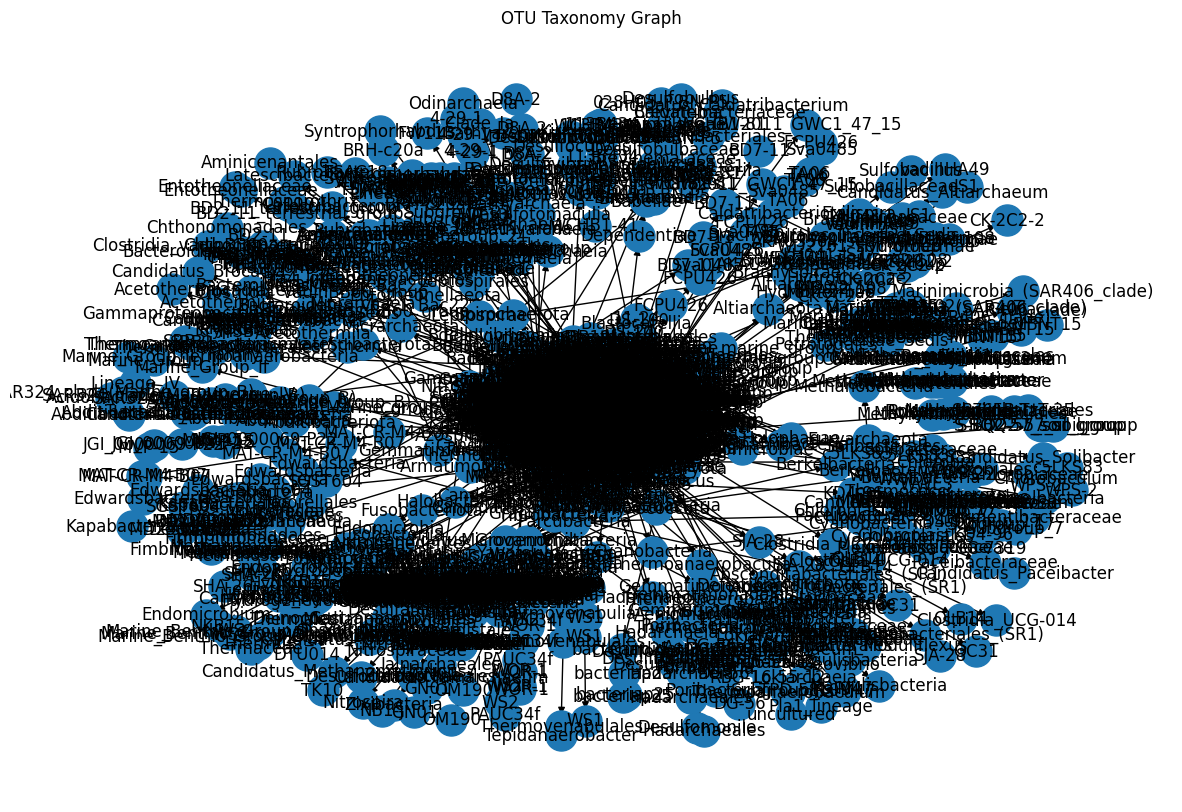

In [6]:
import numpy as np
import pandas as pd
import networkx as nx
from Bio import Phylo
import re
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

def parse_taxonomy(column_name):
    """Parse the full taxonomic string into levels"""
    if isinstance(column_name, str) and ';' in column_name:
        taxa = column_name.split(';')
        return [t.split('__')[1] if '__' in t else t for t in taxa]
    return None

def create_taxonomy_graph():
    """Create a graph structure based on taxonomic relationships"""
    # Read the data
    df = pd.read_csv('Data/New_Data.csv', index_col=0)
    
    # Create directed graph
    G = nx.DiGraph()
    
    # Keep track of valid OTU columns
    otu_columns = []
    
    # Process each OTU column
    for col in df.columns:
        taxa = parse_taxonomy(col)
        if taxa is None:  # Skip non-taxonomy columns
            continue
            
        otu_columns.append(col)
        
        # Add nodes and edges for taxonomy hierarchy
        for i in range(len(taxa)):
            # Add current taxonomic level as node
            current = '_'.join(taxa[:i+1])
            G.add_node(current, 
                      level=i,
                      taxon_name=taxa[i])
            
            # Add edge from parent to current
            if i > 0:
                parent = '_'.join(taxa[:i])
                G.add_edge(parent, current)
    
    return G, df[otu_columns]

def create_abundance_features(G, df):
    """Add abundance features to the graph nodes"""
    # Calculate mean abundance for each OTU
    mean_abundances = df.mean()
    
    # Normalize abundances
    scaler = StandardScaler()
    normalized_abundances = scaler.fit_transform(df)
    mean_normalized = pd.Series(normalized_abundances.mean(axis=0), index=df.columns)
    
    # Add abundance features to leaf nodes (full OTUs)
    for col in df.columns:
        taxa = parse_taxonomy(col)
        if taxa:
            leaf_name = '_'.join(taxa)
            if leaf_name in G.nodes:
                G.nodes[leaf_name]['abundance'] = mean_abundances[col]
                G.nodes[leaf_name]['normalized_abundance'] = mean_normalized[col]
    
    return G

def add_similarity_edges(G, threshold=0.5):
    """Add edges between nodes based on taxonomic similarity"""
    leaf_nodes = [n for n, d in G.nodes(data=True) 
                 if G.out_degree(n) == 0]  # Get leaf nodes
    
    for i, node1 in enumerate(leaf_nodes):
        taxa1 = node1.split('_')
        for node2 in leaf_nodes[i+1:]:
            taxa2 = node2.split('_')
            
            # Calculate taxonomic similarity
            common_levels = sum(1 for t1, t2 in zip(taxa1, taxa2) if t1 == t2)
            similarity = common_levels / max(len(taxa1), len(taxa2))
            
            # Add edge if similarity exceeds threshold
            if similarity >= threshold:
                G.add_edge(node1, node2, weight=similarity)
                G.add_edge(node2, node1, weight=similarity)

def create_node_features(G):
    """Create feature matrix for nodes"""
    features = []
    node_order = list(G.nodes())  # Keep track of node order
    
    for node in node_order:
        node_data = G.nodes[node]
        feature_vector = [
            node_data.get('level', 0),
            node_data.get('abundance', 0),
            node_data.get('normalized_abundance', 0),
            G.in_degree(node),
            G.out_degree(node)
        ]
        features.append(feature_vector)
    
    return np.array(features), node_order

def create_adjacency_matrix(G, node_order):
    """Create adjacency matrix using consistent node order"""
    return nx.adjacency_matrix(G, nodelist=node_order).todense()

def visualize_graph(G):
    """Visualize the graph structure"""
    plt.figure(figsize=(15, 10))
    pos = nx.spring_layout(G)
    
    # Draw nodes
    nx.draw_networkx_nodes(G, pos, node_size=500)
    
    # Draw edges
    nx.draw_networkx_edges(G, pos)
    
    # Draw labels
    labels = {node: G.nodes[node]['taxon_name'] for node in G.nodes()}
    nx.draw_networkx_labels(G, pos, labels)
    
    plt.title("OTU Taxonomy Graph")
    plt.axis('off')
    plt.show()

# Main execution
def main():
    # Create and process the graph
    print("Creating taxonomy graph...")
    G, df = create_taxonomy_graph()
    
    print("Adding abundance features...")
    G = create_abundance_features(G, df)
    
    print("Adding similarity edges...")
    add_similarity_edges(G)
    
    # Create feature and adjacency matrices
    print("Creating feature matrix...")
    node_features, node_order = create_node_features(G)
    
    print("Creating adjacency matrix...")
    adj_matrix = create_adjacency_matrix(G, node_order)
    
    # Print statistics
    print("\nGraph Statistics:")
    print(f"Number of nodes: {G.number_of_nodes()}")
    print(f"Number of edges: {G.number_of_edges()}")
    print(f"Feature matrix shape: {node_features.shape}")
    print(f"Adjacency matrix shape: {adj_matrix.shape}")
    
    # Visualize the graph
    print("\nVisualizing graph...")
    visualize_graph(G)
    
    return G, node_features, adj_matrix, node_order, df

# Run the main function
if __name__ == "__main__":
    G, node_features, adj_matrix, node_order, df = main()

Reading data...

Dataset Info:
Number of samples (rows): 60
Number of features (columns): 1134

First few rows of cleaned data:
   d__Bacteria;p__Firmicutes;c__Clostridia;o__Oscillospirales;f__Ruminococcaceae;g__Faecalibacterium  \
0                                                0.0                                                   
1                                                0.0                                                   
2                                                0.0                                                   
3                                                0.0                                                   
4                                                0.0                                                   

   d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;f__Bacteroidaceae;g__Bacteroides  \
0                                                0.0                                              
1                                                

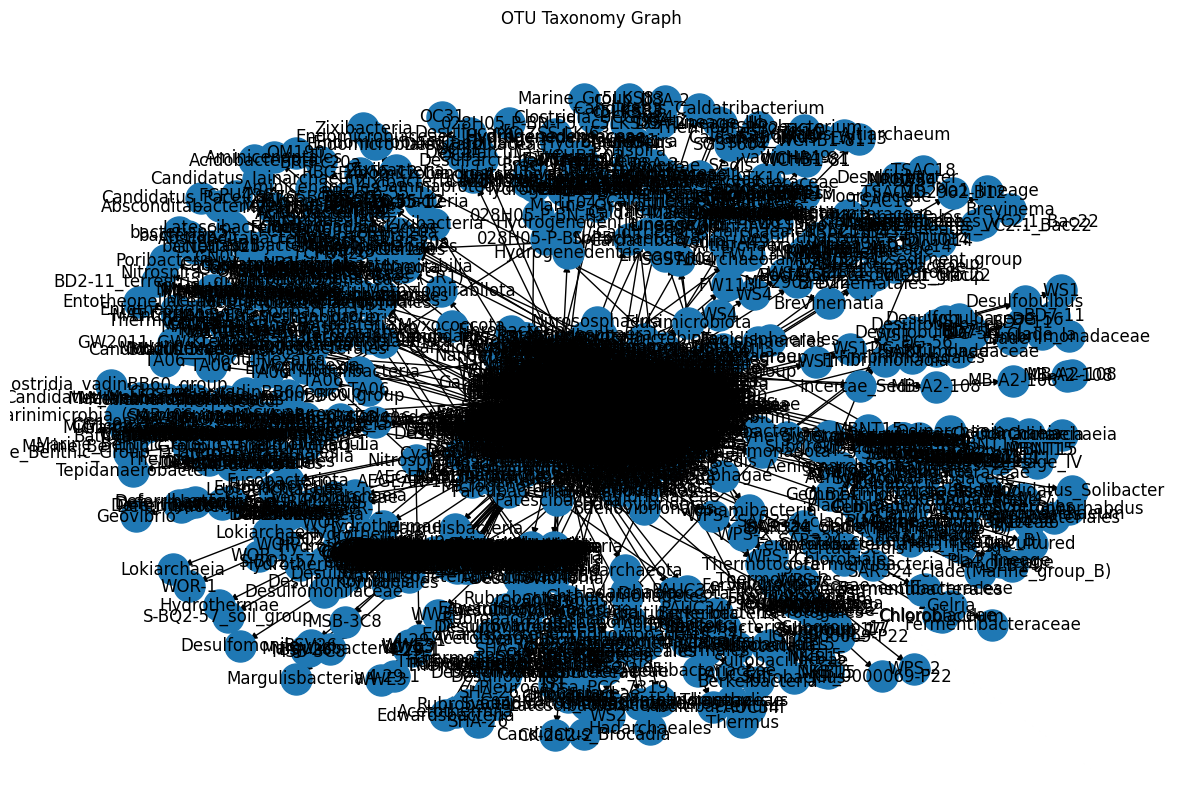

In [1]:
import numpy as np
import pandas as pd
import networkx as nx
from Bio import Phylo
import re
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

def parse_taxonomy(column_name):
    """Parse the full taxonomic string into levels"""
    if isinstance(column_name, str) and ';' in column_name:
        taxa = column_name.split(';')
        return [t.split('__')[1] if '__' in t else t for t in taxa]
    return None

def create_taxonomy_graph():
    """Create a graph structure based on taxonomic relationships"""
    # Read the data and clean it
    df = pd.read_csv('Data/New_Data.csv', index_col=0)
    numeric_df = df.apply(pd.to_numeric, errors='coerce').fillna(0)
    
    # Create directed graph
    G = nx.DiGraph()
    
    # Keep track of valid OTU columns
    otu_columns = []
    
    # Process each OTU column
    for col in df.columns:
        taxa = parse_taxonomy(col)
        if taxa is None:  # Skip non-taxonomy columns
            continue
            
        otu_columns.append(col)
        
        # Add nodes and edges for taxonomy hierarchy
        for i in range(len(taxa)):
            # Add current taxonomic level as node
            current = '_'.join(taxa[:i+1])
            G.add_node(current, 
                      level=i,
                      taxon_name=taxa[i])
            
            # Add edge from parent to current
            if i > 0:
                parent = '_'.join(taxa[:i])
                G.add_edge(parent, current)
    
    return G, numeric_df[otu_columns]

def create_abundance_features(G, df, sample_idx=None):
    """Add abundance features to the graph nodes"""
    # Ensure data is numeric
    df = df.apply(pd.to_numeric, errors='coerce').fillna(0)
    
    if sample_idx is not None:
        # Get abundances for specific sample
        abundances = df.iloc[sample_idx]
        # Normalize abundances for this sample
        scaler = StandardScaler()
        normalized_abundances = scaler.fit_transform(abundances.values.reshape(-1, 1)).flatten()
        normalized_abundances = pd.Series(normalized_abundances, index=df.columns)
    else:
        # Original behavior for mean abundances
        abundances = df.mean()
        scaler = StandardScaler()
        normalized_abundances = scaler.fit_transform(df.values)
        normalized_abundances = pd.Series(normalized_abundances.mean(axis=0), index=df.columns)
    
    # Add abundance features to leaf nodes (full OTUs)
    for col in df.columns:
        taxa = parse_taxonomy(col)
        if taxa:
            leaf_name = '_'.join(taxa)
            if leaf_name in G.nodes:
                G.nodes[leaf_name]['abundance'] = float(abundances[col])
                G.nodes[leaf_name]['normalized_abundance'] = float(normalized_abundances[col])
    
    return G

def add_similarity_edges(G, threshold=0.5):
    """Add edges between nodes based on taxonomic similarity"""
    leaf_nodes = [n for n, d in G.nodes(data=True) 
                 if G.out_degree(n) == 0]  # Get leaf nodes
    
    for i, node1 in enumerate(leaf_nodes):
        taxa1 = node1.split('_')
        for node2 in leaf_nodes[i+1:]:
            taxa2 = node2.split('_')
            
            # Calculate taxonomic similarity
            common_levels = sum(1 for t1, t2 in zip(taxa1, taxa2) if t1 == t2)
            similarity = common_levels / max(len(taxa1), len(taxa2))
            
            # Add edge if similarity exceeds threshold
            if similarity >= threshold:
                G.add_edge(node1, node2, weight=similarity)
                G.add_edge(node2, node1, weight=similarity)

def create_node_features(G):
    """Create feature matrix for nodes"""
    features = []
    node_order = list(G.nodes())  # Keep track of node order
    
    for node in node_order:
        node_data = G.nodes[node]
        feature_vector = [
            node_data.get('level', 0),
            node_data.get('abundance', 0),
            node_data.get('normalized_abundance', 0),
            G.in_degree(node),
            G.out_degree(node)
        ]
        features.append(feature_vector)
    
    return np.array(features), node_order

def create_adjacency_matrix(G, node_order):
    """Create adjacency matrix using consistent node order"""
    return nx.adjacency_matrix(G, nodelist=node_order).todense()

def visualize_graph(G):
    """Visualize the graph structure"""
    plt.figure(figsize=(15, 10))
    pos = nx.spring_layout(G)
    
    # Draw nodes
    nx.draw_networkx_nodes(G, pos, node_size=500)
    
    # Draw edges
    nx.draw_networkx_edges(G, pos)
    
    # Draw labels
    labels = {node: G.nodes[node]['taxon_name'] for node in G.nodes()}
    nx.draw_networkx_labels(G, pos, labels)
    
    plt.title("OTU Taxonomy Graph")
    plt.axis('off')
    plt.show()

def create_sample_graphs(df):
    """Create individual graphs for each sample in the dataset"""
    graphs = []
    features_list = []
    adj_matrices = []
    node_orders = []
    
    # Clean the dataframe once
    df = df.apply(pd.to_numeric, errors='coerce').fillna(0)
    
    for idx in range(len(df)):
        try:
            # Create base taxonomy graph
            G, _ = create_taxonomy_graph()
            
            # Add abundance features for this specific sample
            G = create_abundance_features(G, df, sample_idx=idx)
            
            # Add similarity edges
            add_similarity_edges(G)
            
            # Create feature and adjacency matrices
            node_features, node_order = create_node_features(G)
            adj_matrix = create_adjacency_matrix(G, node_order)
            
            graphs.append(G)
            features_list.append(node_features)
            adj_matrices.append(adj_matrix)
            node_orders.append(node_order)
            
            # Print progress
            if (idx + 1) % 100 == 0:
                print(f"Processed {idx + 1} samples...")
                
        except Exception as e:
            print(f"Error processing sample {idx}: {str(e)}")
            continue
    
    return graphs, features_list, adj_matrices, node_orders

def main():
    # Read and clean the data
    print("Reading data...")
    df = pd.read_csv('Data/New_Data.csv', index_col=0)
    df = df.apply(pd.to_numeric, errors='coerce').fillna(0)
    
    # Print initial data info
    print("\nDataset Info:")
    print(f"Number of samples (rows): {len(df)}")
    print(f"Number of features (columns): {len(df.columns)}")
    print("\nFirst few rows of cleaned data:")
    print(df.head())
    
    # Create graphs for all samples
    print("\nCreating sample graphs...")
    graphs, features_list, adj_matrices, node_orders = create_sample_graphs(df)
    
    # Print statistics
    print("\nDataset Statistics:")
    print(f"Number of samples processed: {len(graphs)}")
    print(f"Number of nodes per graph: {graphs[0].number_of_nodes()}")
    print(f"Feature matrix shape for each graph: {features_list[0].shape}")
    print(f"Adjacency matrix shape for each graph: {adj_matrices[0].shape}")
    
    # Visualize first graph as example
    print("\nVisualizing first sample graph...")
    visualize_graph(graphs[0])
    
    return graphs, features_list, adj_matrices, node_orders, df

# Run the main function
if __name__ == "__main__":
    graphs, features_list, adj_matrices, node_orders, df = main()

In [2]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data, DataLoader
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.preprocessing import LabelEncoder
import pandas as pd

# Convert the graph data into PyTorch Geometric format
def convert_to_pytorch_geometric_data(graphs, features_list, adj_matrices, labels):
    """Convert our graph representations to PyTorch Geometric Data objects"""
    data_list = []
    
    for i in range(len(graphs)):
        # Convert features to tensor
        x = torch.FloatTensor(features_list[i])
        
        # Convert adjacency matrix to edge index format
        edge_index = torch.tensor(np.array(np.nonzero(adj_matrices[i])), dtype=torch.long)
        
        # Create edge weights
        edge_weights = torch.FloatTensor([adj_matrices[i][i,j] for i, j in zip(*np.nonzero(adj_matrices[i]))])
        
        # Convert label to tensor
        y = torch.tensor([labels[i]], dtype=torch.long)
        
        # Create Data object
        data = Data(x=x, 
                   edge_index=edge_index,
                   edge_attr=edge_weights,
                   y=y)
        
        data_list.append(data)
    
    return data_list

# Define the GCN model
class GCN(torch.nn.Module):
    def __init__(self, num_node_features, num_classes, hidden_channels=16):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(num_node_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, hidden_channels)
        self.fc = torch.nn.Linear(hidden_channels, num_classes)
        
        # Add batch normalization
        self.bn1 = torch.nn.BatchNorm1d(hidden_channels)
        self.bn2 = torch.nn.BatchNorm1d(hidden_channels)
        self.bn3 = torch.nn.BatchNorm1d(hidden_channels)
        
    def forward(self, data):
        x, edge_index, edge_weight = data.x, data.edge_index, data.edge_attr
        
        # First Graph Convolution
        x = self.conv1(x, edge_index, edge_weight)
        x = self.bn1(x)
        x = F.relu(x)
        x = F.dropout(x, p=0.3, training=self.training)
        
        # Second Graph Convolution
        x = self.conv2(x, edge_index, edge_weight)
        x = self.bn2(x)
        x = F.relu(x)
        x = F.dropout(x, p=0.3, training=self.training)
        
        # Third Graph Convolution
        x = self.conv3(x, edge_index, edge_weight)
        x = self.bn3(x)
        x = F.relu(x)
        
        # Global mean pooling
        x = torch.mean(x, dim=0)
        
        # Final classification layer
        x = self.fc(x)
        
        return F.log_softmax(x, dim=0)

# Training function
def train_gcn(model, train_loader, optimizer, device):
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output.unsqueeze(0), data.y)
        loss.backward()
        optimizer.step()
        
        # Calculate accuracy
        pred = output.max(dim=0)[1]
        correct += pred.eq(data.y).sum().item()
        total += 1
        total_loss += loss.item()
    
    accuracy = correct / total
    return total_loss / len(train_loader), accuracy

# Evaluation function
def evaluate_gcn(model, loader, device):
    model.eval()
    correct = 0
    total = 0
    
    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            output = model(data)
            pred = output.max(dim=0)[1]
            correct += pred.eq(data.y).sum().item()
            total += 1
    
    return correct / total

# Main training pipeline
def train_and_evaluate_gcn(graphs, features_list, adj_matrices, labels, num_epochs=100):
    # Convert labels to numerical format if they're not already
    le = LabelEncoder()
    labels = le.fit_transform(labels)
    
    # Convert data to PyTorch Geometric format
    print("Converting data to PyTorch Geometric format...")
    data_list = convert_to_pytorch_geometric_data(graphs, features_list, adj_matrices, labels)
    
    # Split into train and test sets
    train_data, test_data = train_test_split(data_list, test_size=0.2, random_state=42)
    
    # Create data loaders
    train_loader = DataLoader(train_data, batch_size=1, shuffle=True)
    test_loader = DataLoader(test_data, batch_size=1)
    
    # Initialize device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    
    # Initialize model
    num_node_features = features_list[0].shape[1]
    num_classes = len(np.unique(labels))
    model = GCN(num_node_features, num_classes).to(device)
    
    # Initialize optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', 
                                                         factor=0.5, patience=10, 
                                                         verbose=True)
    
    # Training loop
    best_acc = 0
    patience = 20
    patience_counter = 0
    
    print("\nStarting training...")
    print(f"Number of training samples: {len(train_data)}")
    print(f"Number of test samples: {len(test_data)}")
    print(f"Number of features per node: {num_node_features}")
    print(f"Number of classes: {num_classes}")
    
    for epoch in range(num_epochs):
        train_loss, train_acc = train_gcn(model, train_loader, optimizer, device)
        test_acc = evaluate_gcn(model, test_loader, device)
        
        # Learning rate scheduling
        scheduler.step(test_acc)
        
        # Save best model
        if test_acc > best_acc:
            best_acc = test_acc
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'best_acc': best_acc,
            }, 'best_gcn_model.pt')
            patience_counter = 0
        else:
            patience_counter += 1
        
        # Print progress
        if (epoch + 1) % 10 == 0:
            print(f'Epoch {epoch+1:03d}, Loss: {train_loss:.4f}, '
                  f'Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')
        
        # Early stopping
        if patience_counter >= patience:
            print(f"Early stopping triggered after epoch {epoch+1}")
            break
    
    # Load best model for final evaluation
    checkpoint = torch.load('best_gcn_model.pt')
    model.load_state_dict(checkpoint['model_state_dict'])
    final_test_acc = evaluate_gcn(model, test_loader, device)
    
    print(f'\nTraining completed!')
    print(f'Best Test Accuracy: {final_test_acc:.4f}')
    
    return model, final_test_acc, le

# Run the training
if __name__ == "__main__":
    # Read your labels
    try:
        # Assuming labels are in a CSV file with columns 'sample_id' and 'label'
        labels_df = pd.read_csv('Data/labels.csv')
        labels = labels_df['label'].values
        
        # Train the model
        model, best_acc, label_encoder = train_and_evaluate_gcn(graphs, features_list, adj_matrices, labels)
        print(f'Training completed successfully!')
        print(f'Label mapping: {dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))}')
        
    except Exception as e:
        print(f"Error during training: {str(e)}")

Error during training: [Errno 2] No such file or directory: 'Data/labels.csv'


Loading data...
Data shape: (60, 1134)
Number of features: 1134
Number of samples: 60

Training models...
Plotting results...


/var/folders/0k/33xc23rd39v28fxtr5xb2gbh0000gn/T/ipykernel_61290/3190865063.py:104: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout()


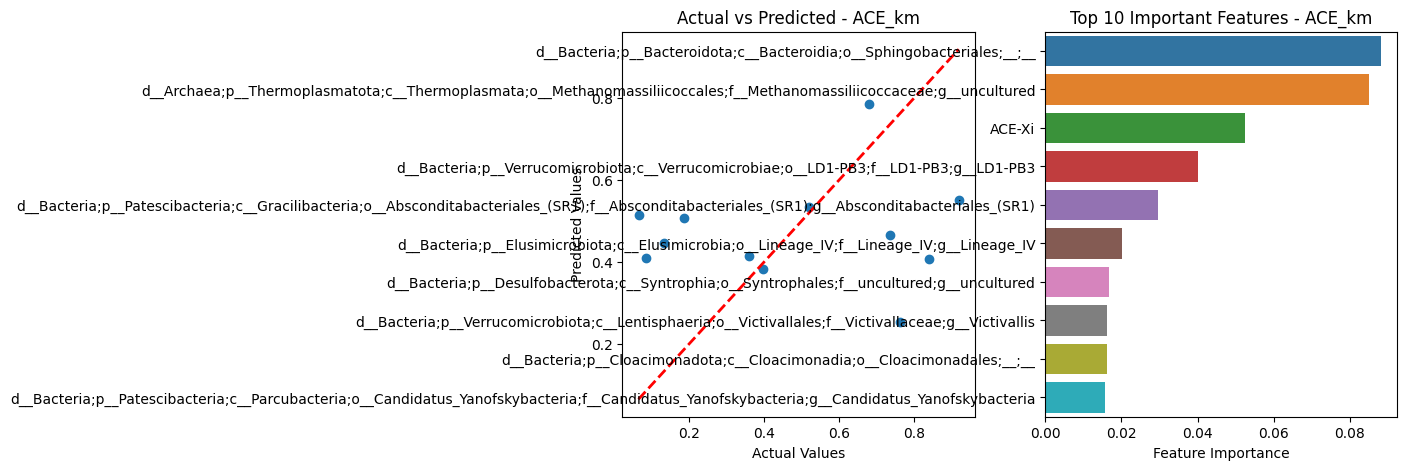

/var/folders/0k/33xc23rd39v28fxtr5xb2gbh0000gn/T/ipykernel_61290/3190865063.py:104: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout()


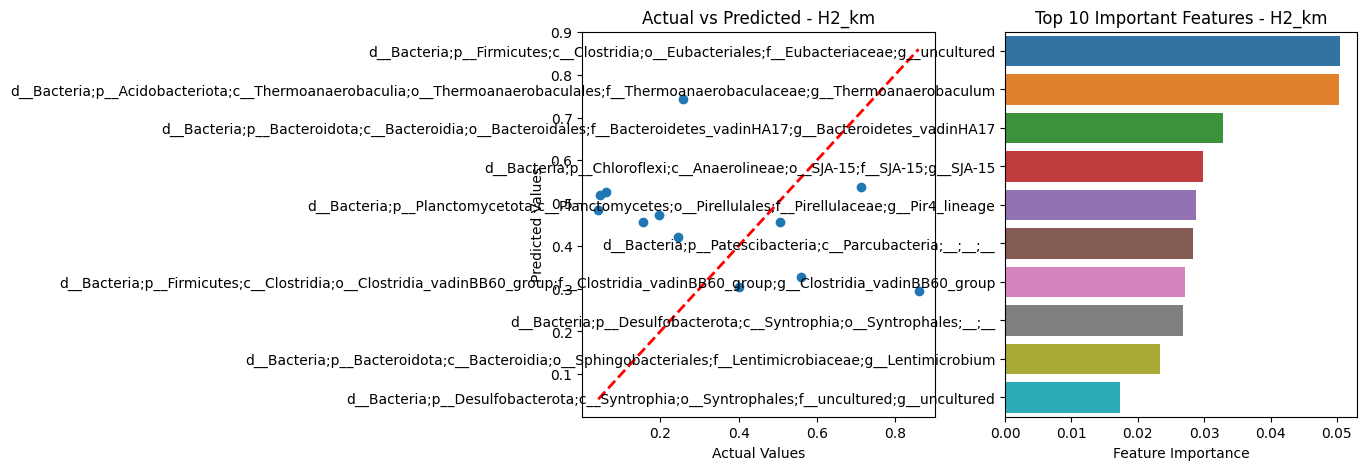


Model Performance Metrics:

Results for ACE_km:
Mean Squared Error: 0.0980
R² Score: -0.1055

Results for H2_km:
Mean Squared Error: 0.1234
R² Score: -0.8266

Example prediction for first 5 samples:
     ACE_km     H2_km
0  0.253881  0.526361
1  0.221883  0.632897
2  0.250686  0.469332
3  0.385123  0.727140
4  0.554322  0.324834


In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

def load_and_prepare_data():
    # Load microbiome data
    X = pd.read_csv('Data/New_Data.csv', index_col=0)
    
    # Replace any string 'x' with 0 and convert to numeric
    X = X.replace('x', 0)
    X = X.apply(pd.to_numeric, errors='coerce')
    
    # Fill any NaN values with 0
    X = X.fillna(0)
    
    # Create example target variables (replace these with your actual values)
    y = pd.DataFrame({
        'ACE_km': np.random.rand(len(X)),  # Replace with actual ACE-km values
        'H2_km': np.random.rand(len(X))    # Replace with actual H2-km values
    })
    
    return X, y

def train_models(X, y):
    # Dictionary to store models and results
    models = {}
    results = {}
    
    # For each target variable
    for target in y.columns:
        # Split data
        X_train, X_test, y_train, y_test = train_test_split(
            X, y[target], test_size=0.2, random_state=42
        )
        
        # Scale features
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        
        # Train model
        model = RandomForestRegressor(
            n_estimators=100,
            max_depth=None,
            min_samples_split=2,
            min_samples_leaf=1,
            random_state=42
        )
        model.fit(X_train_scaled, y_train)
        
        # Make predictions
        y_pred = model.predict(X_test_scaled)
        
        # Calculate metrics
        mse = mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        
        # Store results
        models[target] = {
            'model': model,
            'scaler': scaler
        }
        
        results[target] = {
            'y_test': y_test,
            'y_pred': y_pred,
            'mse': mse,
            'r2': r2,
            'feature_importance': model.feature_importances_
        }
    
    return models, results

def plot_results(results, X):
    for target in results.keys():
        # Plot actual vs predicted
        plt.figure(figsize=(10, 5))
        
        plt.subplot(1, 2, 1)
        plt.scatter(results[target]['y_test'], results[target]['y_pred'])
        plt.plot([min(results[target]['y_test']), max(results[target]['y_test'])],
                 [min(results[target]['y_test']), max(results[target]['y_test'])],
                 'r--', lw=2)
        plt.xlabel('Actual Values')
        plt.ylabel('Predicted Values')
        plt.title(f'Actual vs Predicted - {target}')
        
        # Plot feature importance
        plt.subplot(1, 2, 2)
        importances = pd.Series(
            results[target]['feature_importance'],
            index=X.columns
        ).sort_values(ascending=False)[:10]
        
        sns.barplot(x=importances.values, y=importances.index)
        plt.title(f'Top 10 Important Features - {target}')
        plt.xlabel('Feature Importance')
        
        plt.tight_layout()
        plt.show()

def predict_new_samples(models, new_data):
    predictions = {}
    
    # Clean new data the same way
    new_data = new_data.replace('x', 0)
    new_data = new_data.apply(pd.to_numeric, errors='coerce')
    new_data = new_data.fillna(0)
    
    for target, model_dict in models.items():
        # Scale new data
        new_data_scaled = model_dict['scaler'].transform(new_data)
        
        # Make predictions
        predictions[target] = model_dict['model'].predict(new_data_scaled)
    
    return pd.DataFrame(predictions)

def main():
    try:
        # Load and prepare data
        print("Loading data...")
        X, y = load_and_prepare_data()
        
        print("Data shape:", X.shape)
        print("Number of features:", X.shape[1])
        print("Number of samples:", X.shape[0])
        
        # Train models
        print("\nTraining models...")
        models, results = train_models(X, y)
        
        # Plot results
        print("Plotting results...")
        plot_results(results, X)
        
        # Print performance metrics
        print("\nModel Performance Metrics:")
        for target in results.keys():
            print(f"\nResults for {target}:")
            print(f"Mean Squared Error: {results[target]['mse']:.4f}")
            print(f"R² Score: {results[target]['r2']:.4f}")
        
        # Example of how to make new predictions
        print("\nExample prediction for first 5 samples:")
        example_predictions = predict_new_samples(models, X.iloc[:5])
        print(example_predictions)
        
    except Exception as e:
        print(f"An error occurred: {str(e)}")
        raise

if __name__ == "__main__":
    main()